# Insurance Fraud Detection System

## Project Overview
This project aims to develop an automatic fraud detection system using machine learning techniques to analyze insurance claims data and detect suspicious activities.

### Objectives:
- Develop a machine learning model that detects fraud
- Improve detection accuracy via advanced data preprocessing and feature engineering
- Compare multiple ML models and select the best performing one
- Create visualizations for model performance and data insights
- Ensure robust evaluation with proper train/test split

## 1. Import Required Libraries

In [5]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Feature engineering and selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Utilities
import warnings
import joblib
from datetime import datetime
import re

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Initial Exploration

In [6]:
# Load the dataset
df = pd.read_csv('insurance_claims.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1000, 39)

Columns: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported']

First few rows:


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17/10/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27/06/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06/09/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25/05/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06/06/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [7]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\n" + "="*50)
print("Statistical Summary:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insur

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing Values Analysis:")
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

if missing_df['Missing Count'].sum() == 0:
    print("\nGreat! No missing values found in the dataset.")

Missing Values Analysis:
                       Missing Count  Missing Percentage
authorities_contacted             91                 9.1


Target Variable Distribution:
Fraud (Y): 247 (24.70%)
No Fraud (N): 753 (75.30%)


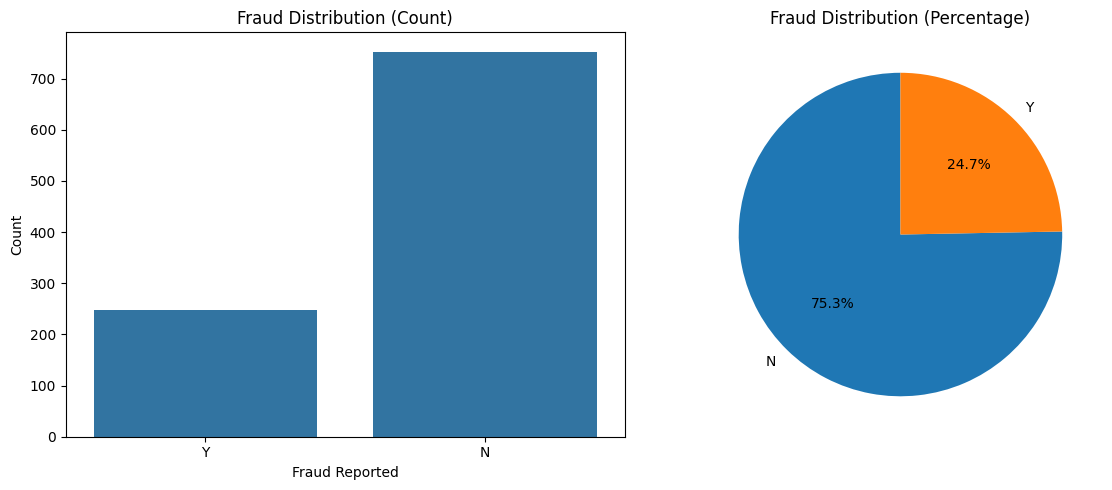


Imbalance Ratio (No Fraud : Fraud): 3.05:1
⚠️  Dataset is imbalanced. We'll need to handle this during model training.


In [9]:
# Target variable analysis
target_counts = df['fraud_reported'].value_counts()
target_percentage = df['fraud_reported'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"Fraud (Y): {target_counts['Y']} ({target_percentage['Y']:.2f}%)")
print(f"No Fraud (N): {target_counts['N']} ({target_percentage['N']:.2f}%)")

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df, x='fraud_reported', ax=ax1)
ax1.set_title('Fraud Distribution (Count)')
ax1.set_xlabel('Fraud Reported')
ax1.set_ylabel('Count')

# Pie chart
ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Fraud Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Check if dataset is imbalanced
imbalance_ratio = target_counts['N'] / target_counts['Y']
print(f"\nImbalance Ratio (No Fraud : Fraud): {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("⚠️  Dataset is imbalanced. We'll need to handle this during model training.")

## 3. Exploratory Data Analysis (EDA)

In [10]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from feature lists
if 'fraud_reported' in categorical_cols:
    categorical_cols.remove('fraud_reported')

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numerical columns (18): ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year']

Categorical columns (20): ['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model']


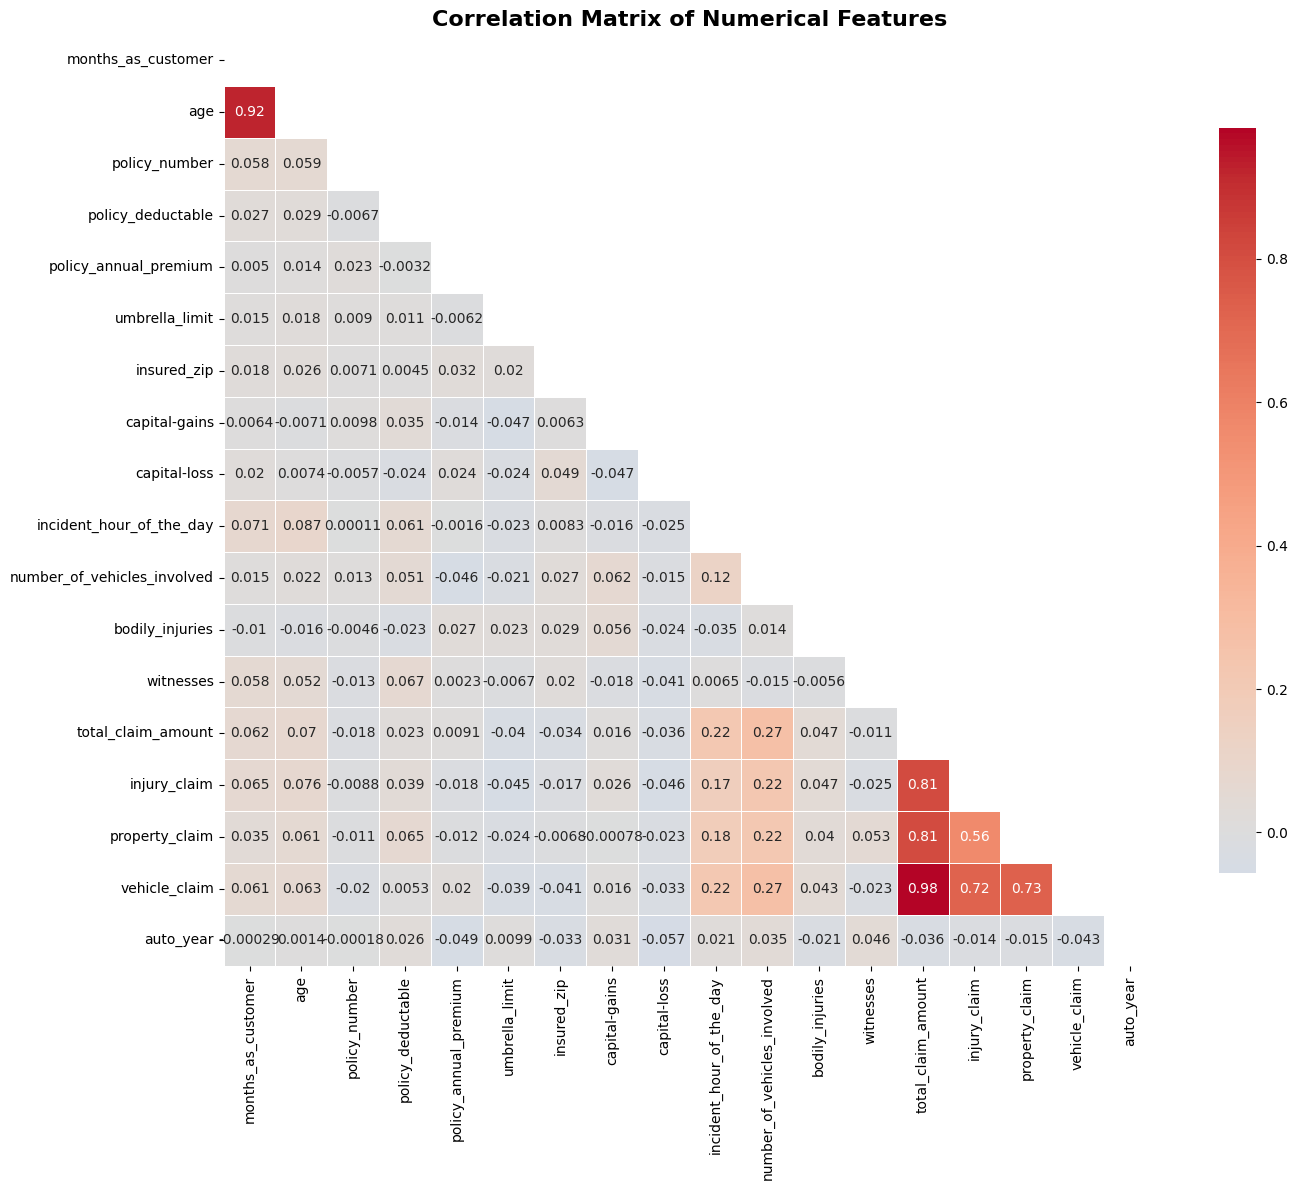


Highly correlated feature pairs (correlation > 0.8):
months_as_customer - age: 0.922
total_claim_amount - injury_claim: 0.805
total_claim_amount - property_claim: 0.811
total_claim_amount - vehicle_claim: 0.983


In [11]:
# Correlation matrix for numerical features
plt.figure(figsize=(15, 12))
correlation_matrix = df[numerical_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (correlation > 0.8):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print("\nNo highly correlated feature pairs found.")

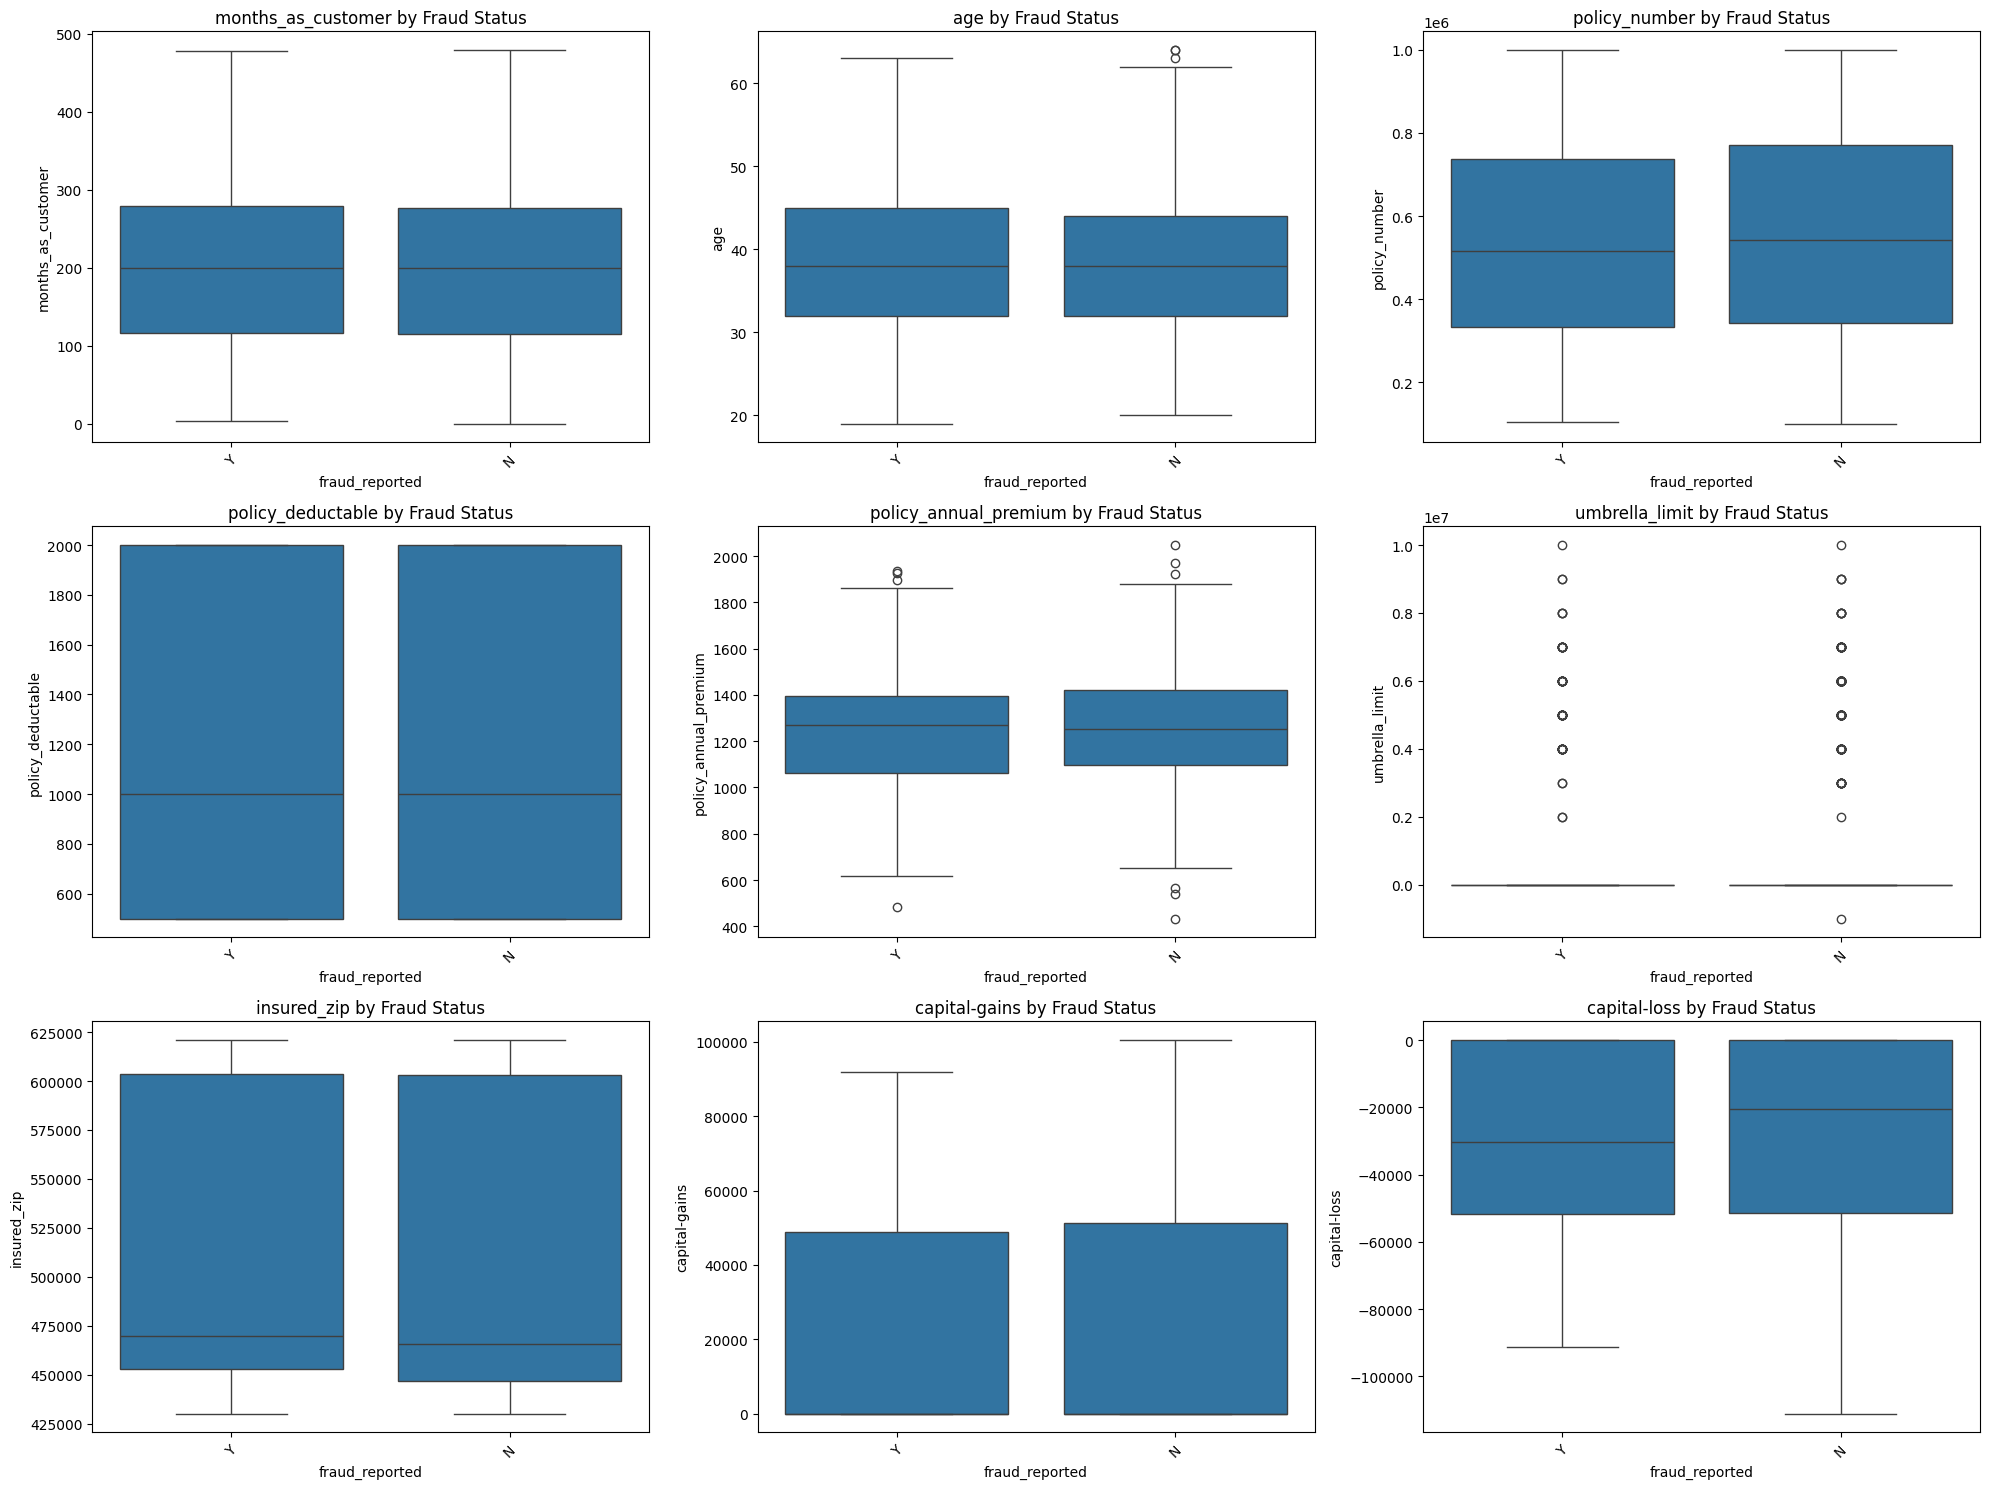

In [12]:
# Distribution of numerical features by fraud status
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:9]):
    sns.boxplot(data=df, x='fraud_reported', y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Fraud Status')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

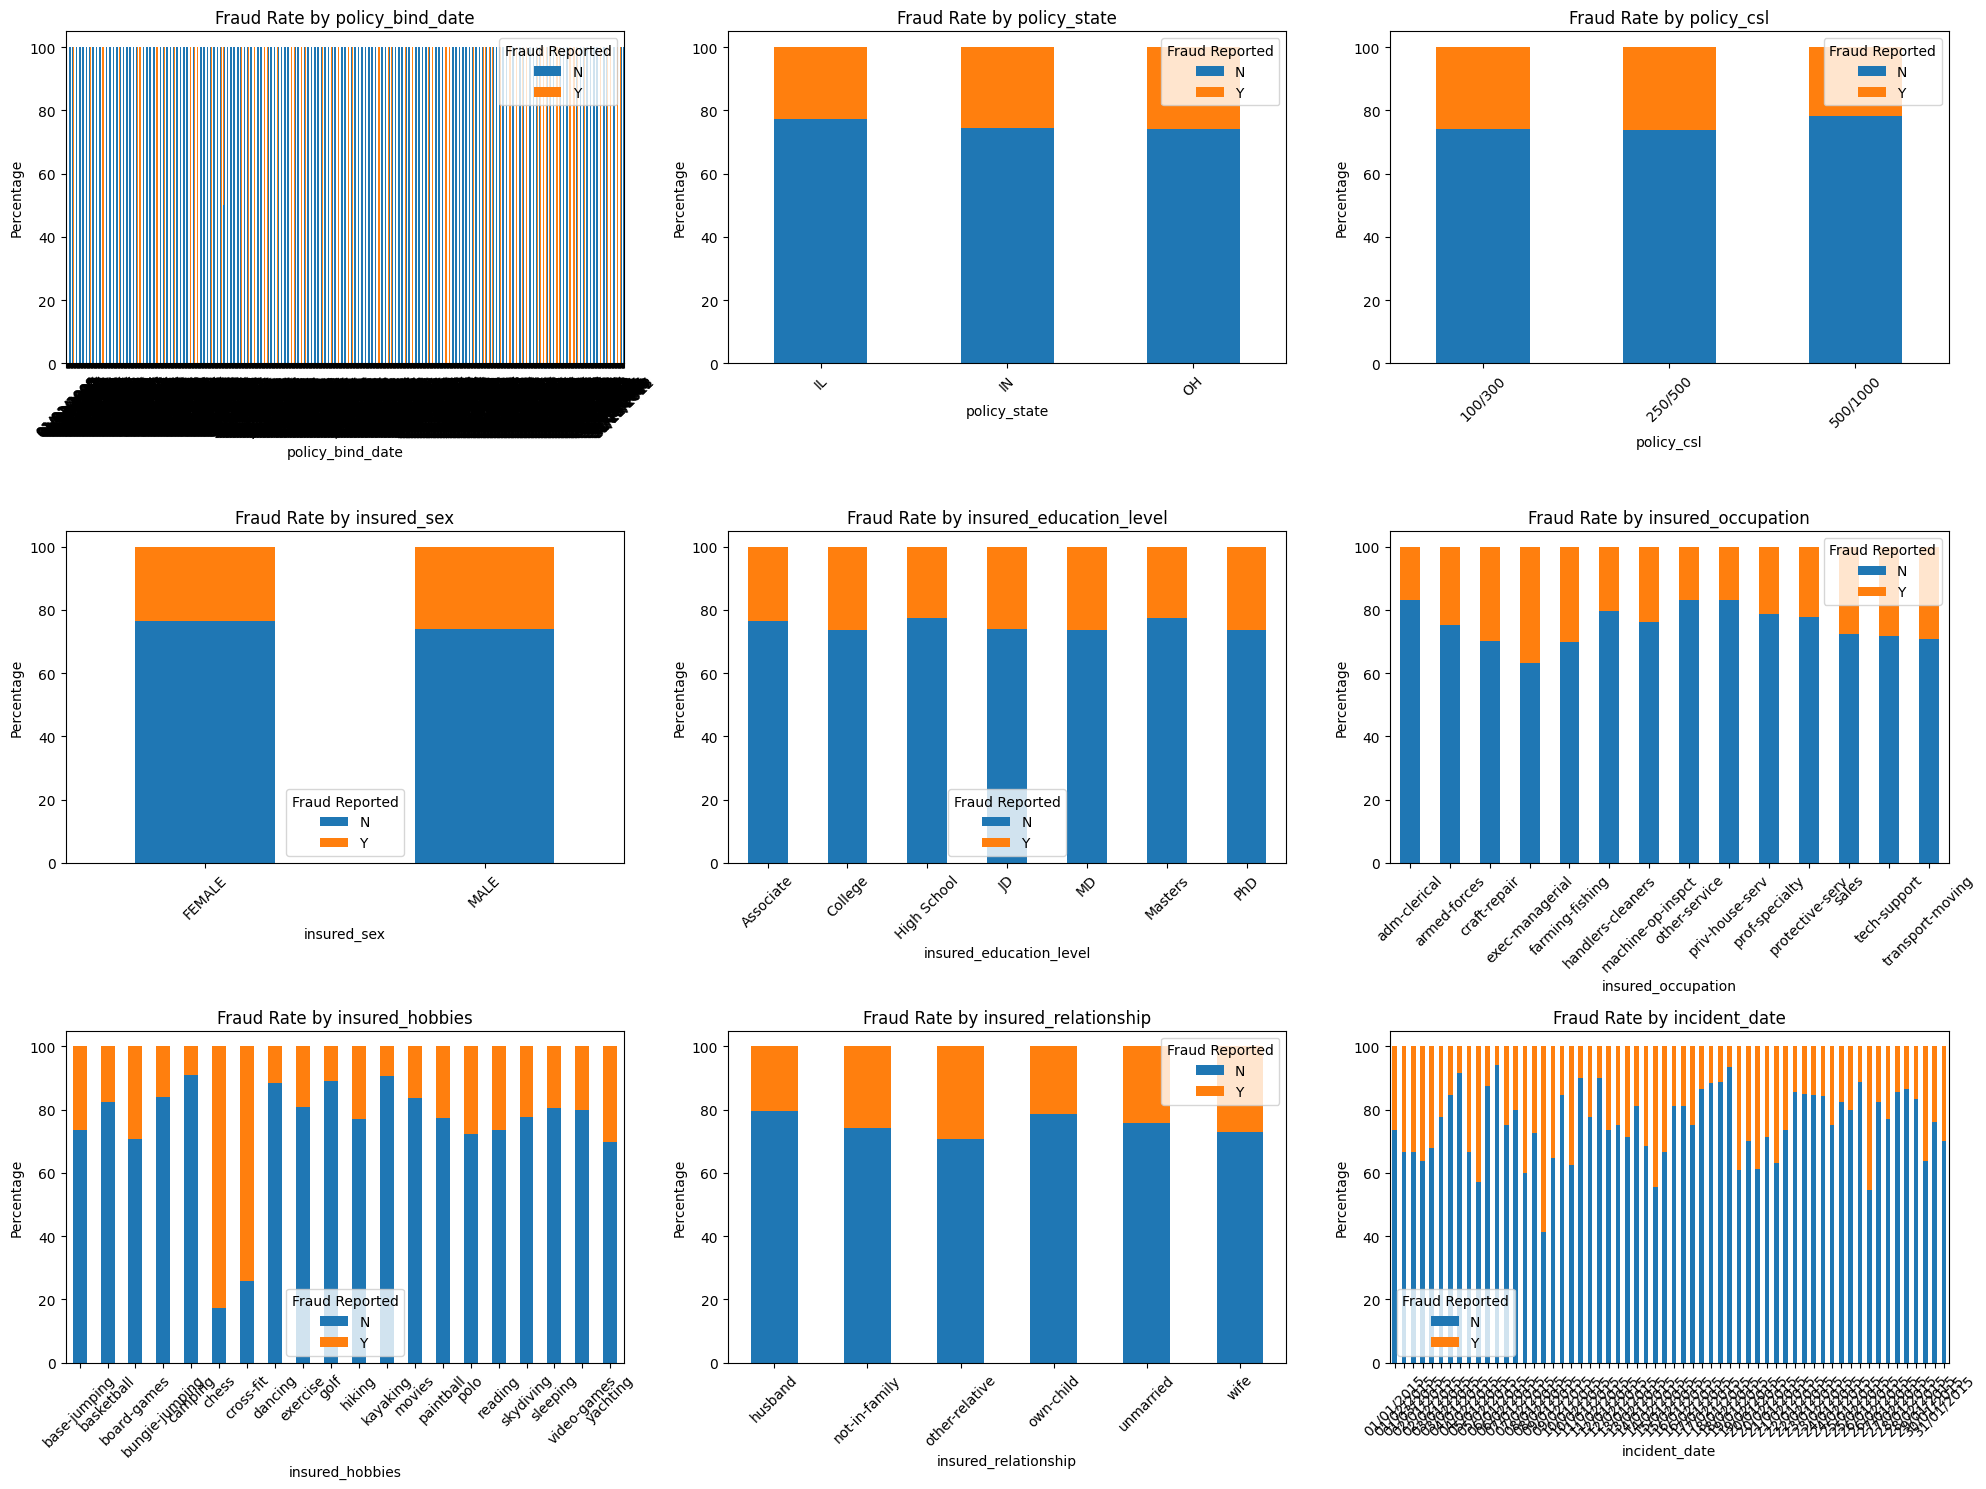

In [13]:
# Categorical features analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:9]):
    if idx < len(axes):
        # Create cross-tabulation
        cross_tab = pd.crosstab(df[col], df['fraud_reported'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], stacked=True)
        axes[idx].set_title(f'Fraud Rate by {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend(title='Fraud Reported')

plt.tight_layout()
plt.show()

In [ ]:
# Claim amount distribution by fraud status
fig = px.box(df, x='fraud_reported', y='total_claim_amount', 
             title='Total Claim Amount Distribution by Fraud Status',
             color='fraud_reported')
fig.show()

# Age distribution by fraud status
fig = px.histogram(df, x='age', color='fraud_reported', 
                   title='Age Distribution by Fraud Status',
                   marginal='box', nbins=30)
fig.show()

# Vehicle year vs fraud
fig = px.scatter(df, x='auto_year', y='total_claim_amount', 
                 color='fraud_reported', size='age',
                 title='Vehicle Year vs Claim Amount (sized by age)')
fig.show()

## 4. Data Preprocessing and Feature Engineering

In [15]:
# Create a copy for preprocessing
df_processed = df.copy()

# Feature Engineering
print("Creating new features...")

# 1. Age groups
df_processed['age_group'] = pd.cut(df_processed['age'], 
                                   bins=[0, 25, 35, 50, 65, 100], 
                                   labels=['Young', 'Adult', 'Middle-aged', 'Senior', 'Elderly'])

# 2. Vehicle age
current_year = datetime.now().year
df_processed['vehicle_age'] = current_year - df_processed['auto_year']

# 3. Claim amount per vehicle
df_processed['claim_per_vehicle'] = df_processed['total_claim_amount'] / df_processed['number_of_vehicles_involved']

# 4. Is weekend incident (assuming incident_hour_of_the_day represents time)
df_processed['is_night_incident'] = (df_processed['incident_hour_of_the_day'] >= 22) | (df_processed['incident_hour_of_the_day'] <= 6)

# 5. High value claim (top 25%)
claim_75th = df_processed['total_claim_amount'].quantile(0.75)
df_processed['high_value_claim'] = df_processed['total_claim_amount'] > claim_75th

# 6. Customer tenure groups
df_processed['tenure_group'] = pd.cut(df_processed['months_as_customer'], 
                                      bins=[0, 12, 36, 60, 1000], 
                                      labels=['New', 'Short-term', 'Medium-term', 'Long-term'])

# 7. Claim severity score (combining different claim types)
df_processed['total_claim_ratio'] = (df_processed['injury_claim'] + 
                                     df_processed['property_claim'] + 
                                     df_processed['vehicle_claim']) / df_processed['total_claim_amount']

print("New features created:")
new_features = ['age_group', 'vehicle_age', 'claim_per_vehicle', 'is_night_incident', 
                'high_value_claim', 'tenure_group', 'total_claim_ratio']
print(new_features)

Creating new features...
New features created:
['age_group', 'vehicle_age', 'claim_per_vehicle', 'is_night_incident', 'high_value_claim', 'tenure_group', 'total_claim_ratio']


In [16]:
# Handle categorical variables with Label Encoding
label_encoders = {}
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()

# Remove target variable
if 'fraud_reported' in categorical_features:
    categorical_features.remove('fraud_reported')

print("Encoding categorical variables...")
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Encode target variable
target_encoder = LabelEncoder()
df_processed['fraud_reported_encoded'] = target_encoder.fit_transform(df_processed['fraud_reported'])
print(f"\nTarget encoding: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Encoding categorical variables...
Encoded policy_bind_date: 951 unique values
Encoded policy_state: 3 unique values
Encoded policy_csl: 3 unique values
Encoded insured_sex: 2 unique values
Encoded insured_education_level: 7 unique values
Encoded insured_occupation: 14 unique values
Encoded insured_hobbies: 20 unique values
Encoded insured_relationship: 6 unique values
Encoded incident_date: 60 unique values
Encoded incident_type: 4 unique values
Encoded collision_type: 4 unique values
Encoded incident_severity: 4 unique values
Encoded authorities_contacted: 5 unique values
Encoded incident_state: 7 unique values
Encoded incident_city: 7 unique values
Encoded incident_location: 1000 unique values
Encoded property_damage: 3 unique values
Encoded police_report_available: 3 unique values
Encoded auto_make: 14 unique values
Encoded auto_model: 39 unique values

Target encoding: {'N': 0, 'Y': 1}


In [17]:
# Prepare feature matrix and target vector
# Select features for modeling
feature_columns = (
    numerical_cols + 
    [col + '_encoded' for col in categorical_features] +
    ['vehicle_age', 'claim_per_vehicle', 'total_claim_ratio'] +
    ['is_night_incident', 'high_value_claim']
)

# Remove any columns that might not exist
feature_columns = [col for col in feature_columns if col in df_processed.columns]

X = df_processed[feature_columns]
y = df_processed['fraud_reported_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features used: {feature_columns}")

Feature matrix shape: (1000, 43)
Target vector shape: (1000,)
Features used: ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year', 'policy_bind_date_encoded', 'policy_state_encoded', 'policy_csl_encoded', 'insured_sex_encoded', 'insured_education_level_encoded', 'insured_occupation_encoded', 'insured_hobbies_encoded', 'insured_relationship_encoded', 'incident_date_encoded', 'incident_type_encoded', 'collision_type_encoded', 'incident_severity_encoded', 'authorities_contacted_encoded', 'incident_state_encoded', 'incident_city_encoded', 'incident_location_encoded', 'property_damage_encoded', 'police_report_available_encoded', 'auto_make_encoded', 'auto_model_encoded', 'vehicle_age', 'claim_per_vehicle', 'total_

In [18]:
# Handle infinite and NaN values
print("Checking for infinite and NaN values...")
print(f"Infinite values: {np.isinf(X).sum().sum()}")
print(f"NaN values: {X.isnull().sum().sum()}")

# Replace infinite values with NaN and then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"After cleaning - Infinite values: {np.isinf(X).sum().sum()}")
print(f"After cleaning - NaN values: {X.isnull().sum().sum()}")

Checking for infinite and NaN values...
Infinite values: 0
NaN values: 0
After cleaning - Infinite values: 0
After cleaning - NaN values: 0


## 5. Feature Selection and Scaling

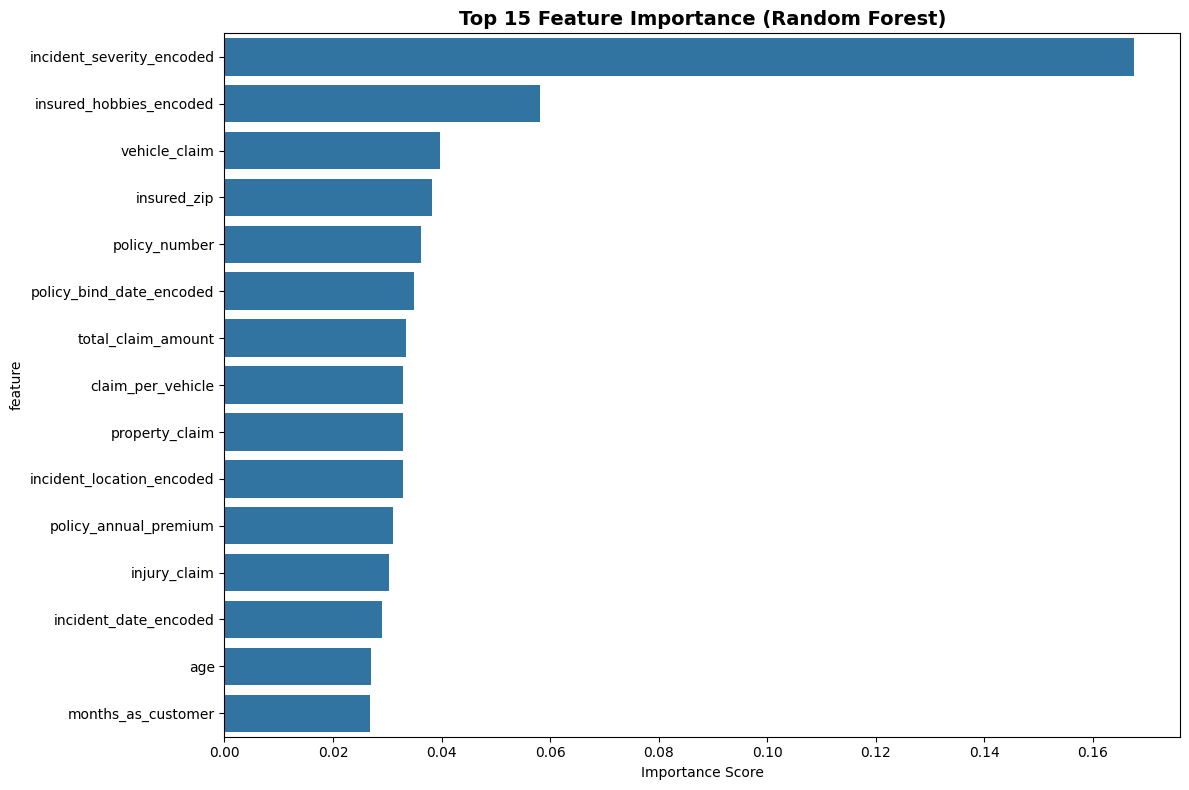

Top 10 most important features:
                      feature  importance
29  incident_severity_encoded    0.167671
24    insured_hobbies_encoded    0.058136
16              vehicle_claim    0.039642
6                 insured_zip    0.038278
2               policy_number    0.036278
18   policy_bind_date_encoded    0.034877
13         total_claim_amount    0.033409
39          claim_per_vehicle    0.032959
15             property_claim    0.032920
33  incident_location_encoded    0.032874


In [19]:
# Feature importance using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

In [20]:
# Select top K features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print(f"Selected {len(selected_features)} features:")
print(list(selected_features))

# Update X with selected features
X = pd.DataFrame(X_selected, columns=selected_features)

Selected 20 features:
['months_as_customer', 'age', 'policy_annual_premium', 'umbrella_limit', 'number_of_vehicles_involved', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'policy_bind_date_encoded', 'policy_state_encoded', 'insured_hobbies_encoded', 'incident_type_encoded', 'collision_type_encoded', 'incident_severity_encoded', 'auto_model_encoded', 'vehicle_age', 'claim_per_vehicle', 'total_claim_ratio', 'high_value_claim']


In [21]:
# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Testing target distribution: {np.bincount(y_test)}")

Training set shape: (800, 20)
Testing set shape: (200, 20)
Training target distribution: [602 198]
Testing target distribution: [151  49]


In [22]:
# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")
print(f"Training data scaled shape: {X_train_scaled.shape}")
print(f"Testing data scaled shape: {X_test_scaled.shape}")

Features scaled using RobustScaler
Training data scaled shape: (800, 20)
Testing data scaled shape: (200, 20)


## 6. Handle Class Imbalance

In [23]:
# Check class distribution
print("Original class distribution:")
print(f"Class 0 (No Fraud): {np.sum(y_train == 0)}")
print(f"Class 1 (Fraud): {np.sum(y_train == 1)}")

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE balancing:")
print(f"Class 0 (No Fraud): {np.sum(y_train_balanced == 0)}")
print(f"Class 1 (Fraud): {np.sum(y_train_balanced == 1)}")
print(f"Balanced training set shape: {X_train_balanced.shape}")

Original class distribution:
Class 0 (No Fraud): 602
Class 1 (Fraud): 198

After SMOTE balancing:
Class 0 (No Fraud): 602
Class 1 (Fraud): 602
Balanced training set shape: (1204, 20)

After SMOTE balancing:
Class 0 (No Fraud): 602
Class 1 (Fraud): 602
Balanced training set shape: (1204, 20)


## 7. Model Training and Comparison

In [24]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

print(f"Training {len(models)} different models...")

Training 10 different models...


In [25]:
# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\nAll models trained successfully!")


Training Logistic Regression...
Logistic Regression - Accuracy: 0.7150, F1: 0.5899, ROC-AUC: 0.8242

Training Random Forest...
Logistic Regression - Accuracy: 0.7150, F1: 0.5899, ROC-AUC: 0.8242

Training Random Forest...
Random Forest - Accuracy: 0.8200, F1: 0.6471, ROC-AUC: 0.8273

Training Gradient Boosting...
Random Forest - Accuracy: 0.8200, F1: 0.6471, ROC-AUC: 0.8273

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.8300, F1: 0.6852, ROC-AUC: 0.8267

Training XGBoost...
Gradient Boosting - Accuracy: 0.8300, F1: 0.6852, ROC-AUC: 0.8267

Training XGBoost...
XGBoost - Accuracy: 0.7950, F1: 0.5773, ROC-AUC: 0.8189

Training LightGBM...
XGBoost - Accuracy: 0.7950, F1: 0.5773, ROC-AUC: 0.8189

Training LightGBM...
LightGBM - Accuracy: 0.8100, F1: 0.6042, ROC-AUC: 0.8189

Training SVM...
LightGBM - Accuracy: 0.8100, F1: 0.6042, ROC-AUC: 0.8189

Training SVM...
SVM - Accuracy: 0.6500, F1: 0.2222, ROC-AUC: 0.5776

Training Naive Bayes...
Naive Bayes - Accuracy: 0.6500, F1: 

In [26]:
# Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find the best model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"Best F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")

Model Performance Comparison:
                    Accuracy Precision    Recall  F1-Score   ROC-AUC
Gradient Boosting       0.83  0.627119  0.755102  0.685185  0.826733
AdaBoost                0.83  0.631579  0.734694  0.679245  0.851737
Random Forest           0.82  0.622642  0.673469  0.647059  0.827342
LightGBM                0.81  0.617021  0.591837  0.604167  0.818894
Logistic Regression    0.715  0.455556  0.836735  0.589928  0.824165
XGBoost                0.795  0.583333  0.571429   0.57732  0.818894
Decision Tree           0.78  0.545455  0.612245  0.576923  0.723341
K-Nearest Neighbors    0.565  0.297872  0.571429  0.391608  0.585687
SVM                     0.65  0.243902  0.204082  0.222222  0.577646
Naive Bayes             0.65  0.243902  0.204082  0.222222  0.591161

🏆 Best performing model: Gradient Boosting
Best F1-Score: 0.6852


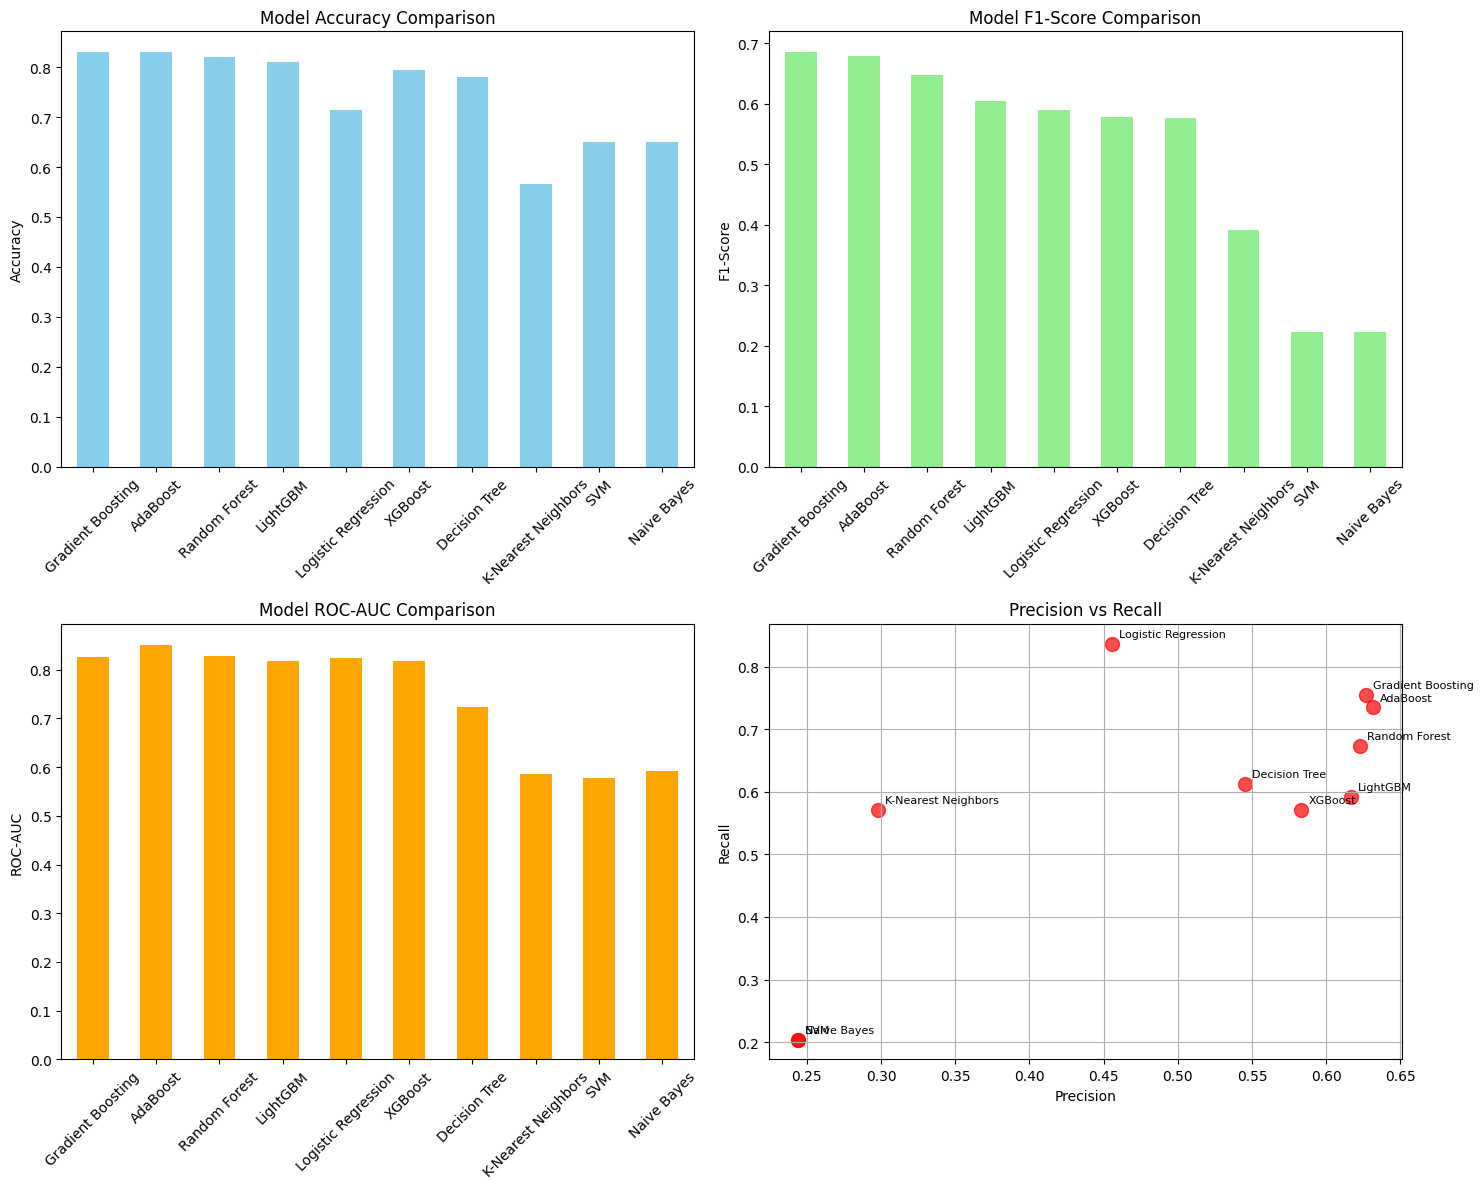

In [27]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
comparison_df['Accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score comparison
comparison_df['F1-Score'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Model F1-Score Comparison')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
comparison_df['ROC-AUC'].plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Model ROC-AUC Comparison')
axes[1,0].set_ylabel('ROC-AUC')
axes[1,0].tick_params(axis='x', rotation=45)

# Precision vs Recall scatter plot
axes[1,1].scatter(comparison_df['Precision'], comparison_df['Recall'], 
                  s=100, alpha=0.7, c='red')
for i, model in enumerate(comparison_df.index):
    axes[1,1].annotate(model, (comparison_df['Precision'].iloc[i], 
                               comparison_df['Recall'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,1].set_xlabel('Precision')
axes[1,1].set_ylabel('Recall')
axes[1,1].set_title('Precision vs Recall')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## 8. Detailed Analysis of Best Model

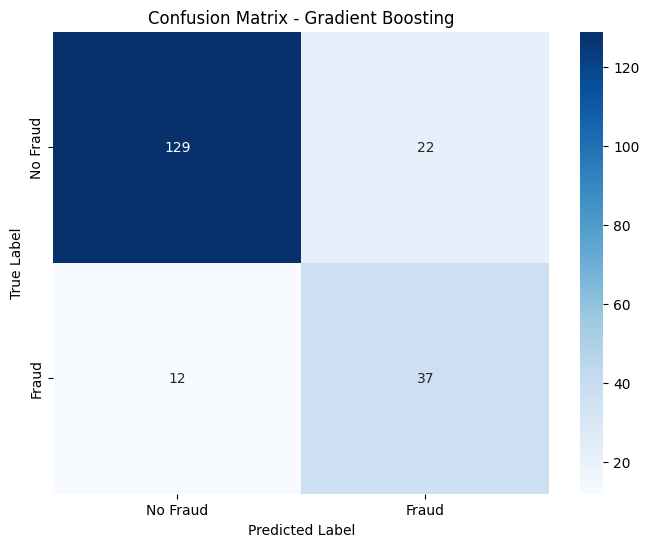


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

    No Fraud       0.91      0.85      0.88       151
       Fraud       0.63      0.76      0.69        49

    accuracy                           0.83       200
   macro avg       0.77      0.80      0.78       200
weighted avg       0.84      0.83      0.83       200



In [28]:
# Detailed evaluation of the best model
best_predictions = model_results[best_model_name]['Predictions']
best_probabilities = model_results[best_model_name]['Probabilities']

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions, 
                          target_names=['No Fraud', 'Fraud']))

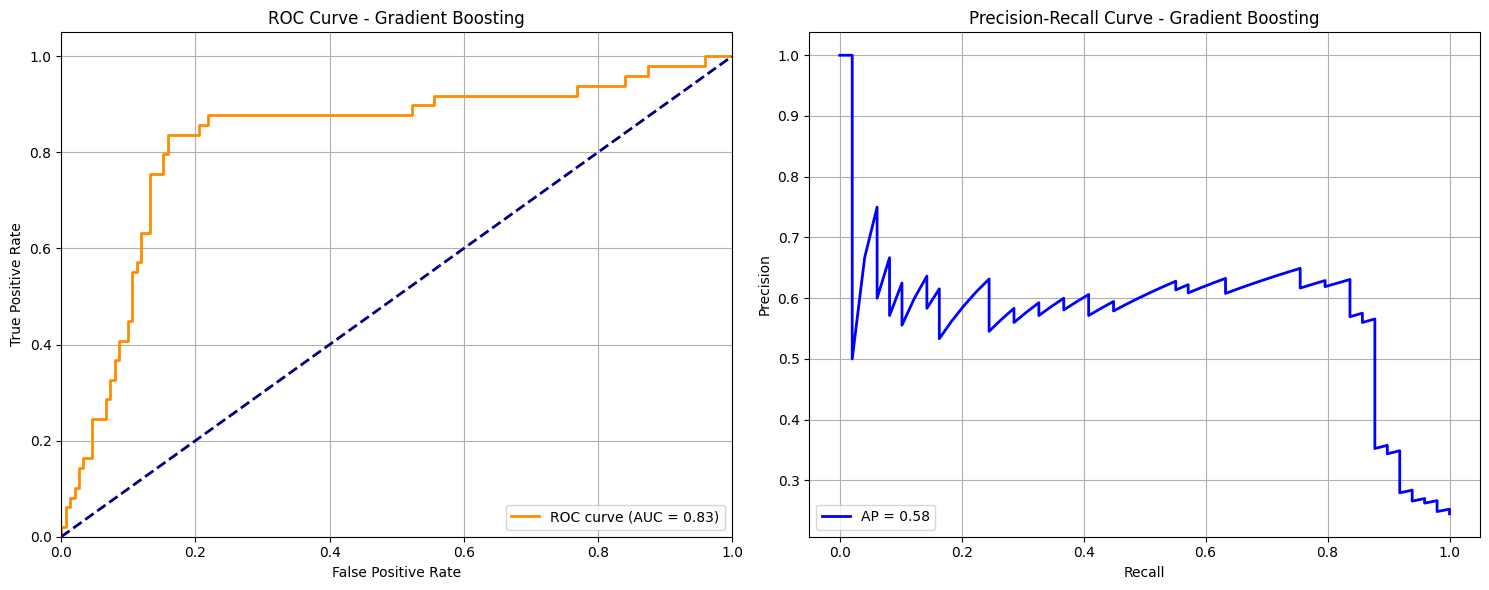

In [29]:
# ROC Curve and Precision-Recall Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_probabilities)
roc_auc = roc_auc_score(y_test, best_probabilities)

ax1.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'ROC Curve - {best_model_name}')
ax1.legend(loc="lower right")
ax1.grid(True)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, best_probabilities)
avg_precision = average_precision_score(y_test, best_probabilities)

ax2.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'AP = {avg_precision:.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(f'Precision-Recall Curve - {best_model_name}')
ax2.legend(loc="lower left")
ax2.grid(True)

plt.tight_layout()
plt.show()

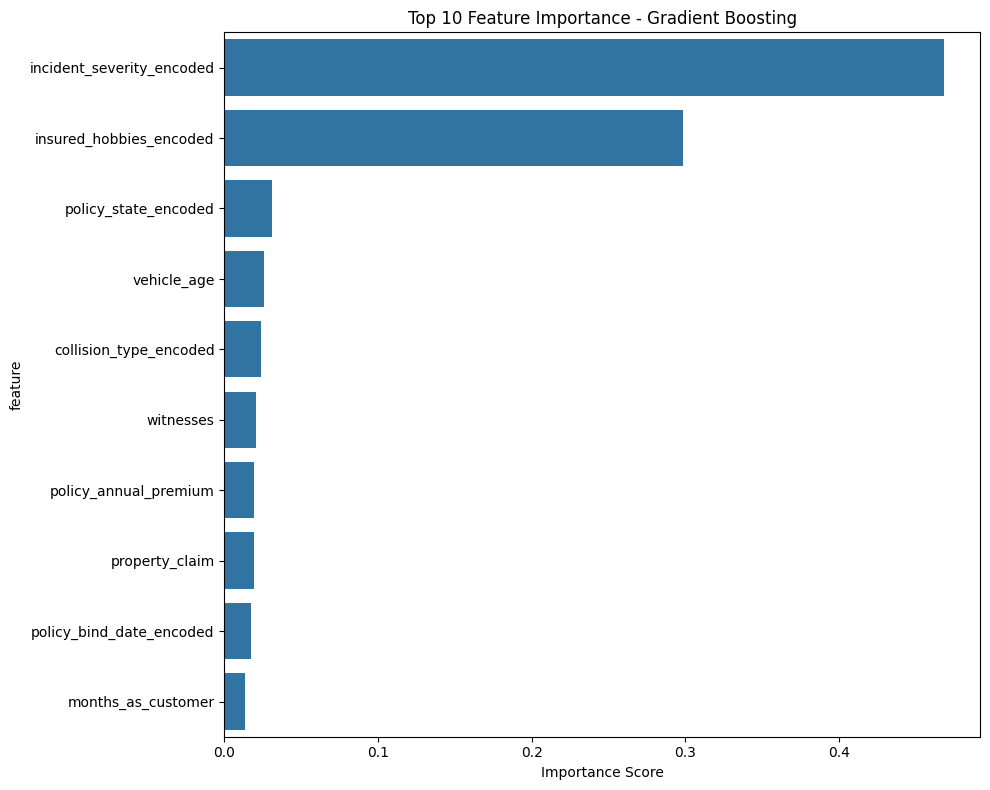

Top 10 most important features:
                      feature  importance
14  incident_severity_encoded    0.468521
11    insured_hobbies_encoded    0.298714
10       policy_state_encoded    0.031281
16                vehicle_age    0.025942
13     collision_type_encoded    0.023573
5                   witnesses    0.020422
2       policy_annual_premium    0.019143
8              property_claim    0.019100
9    policy_bind_date_encoded    0.017596
0          months_as_customer    0.013239


In [ ]:
# Feature importance for the best model 
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_imp.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(feature_imp.head(10))
else:
    print(f"{best_model_name} does not provide feature importance.")

## 9. Model Optimization and Cross-Validation

In [31]:
# Hyperparameter tuning for the best model
print(f"Optimizing {best_model_name} with GridSearchCV...")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

if best_model_name in param_grids:
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=type(best_model)(**best_model.get_params()),
        param_grid=param_grids[best_model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")
    
    # Update best model with optimized parameters
    best_model_optimized = grid_search.best_estimator_
else:
    print(f"No parameter grid defined for {best_model_name}. Using default parameters.")
    best_model_optimized = best_model

Optimizing Gradient Boosting with GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation F1-score: 0.8896

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation F1-score: 0.8896


In [32]:
# Cross-validation scores
cv_scores = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, 
                           cv=5, scoring='f1')

print(f"\nCross-validation F1-scores: {cv_scores}")
print(f"Mean CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final evaluation on test set
final_predictions = best_model_optimized.predict(X_test_scaled)
final_probabilities = best_model_optimized.predict_proba(X_test_scaled)[:, 1]

final_metrics = {
    'Accuracy': accuracy_score(y_test, final_predictions),
    'Precision': precision_score(y_test, final_predictions),
    'Recall': recall_score(y_test, final_predictions),
    'F1-Score': f1_score(y_test, final_predictions),
    'ROC-AUC': roc_auc_score(y_test, final_probabilities)
}

print(f"\nFinal optimized model performance:")
for metric, score in final_metrics.items():
    print(f"{metric}: {score:.4f}")


Cross-validation F1-scores: [0.83555556 0.86206897 0.89494163 0.93227092 0.92307692]
Mean CV F1-score: 0.8896 (+/- 0.0729)

Final optimized model performance:
Accuracy: 0.8150
Precision: 0.6071
Recall: 0.6939
F1-Score: 0.6476
ROC-AUC: 0.8058


## 10. Model Saving and Deployment Preparation

In [33]:
# Save the best model and preprocessing components
model_artifacts = {
    'model': best_model_optimized,
    'scaler': scaler,
    'feature_selector': selector,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'selected_features': list(selected_features),
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'performance_metrics': final_metrics
}

# Save the model
joblib.dump(model_artifacts, 'fraud_detection_model.pkl')
print("✅ Model and preprocessing components saved successfully!")

# Save model summary
summary = f"""
INSURANCE FRAUD DETECTION MODEL SUMMARY
======================================

Best Model: {best_model_name}
Training Data Size: {X_train.shape[0]} samples
Test Data Size: {X_test.shape[0]} samples
Number of Features: {len(selected_features)}

Performance Metrics:
- Accuracy: {final_metrics['Accuracy']:.4f}
- Precision: {final_metrics['Precision']:.4f}
- Recall: {final_metrics['Recall']:.4f}
- F1-Score: {final_metrics['F1-Score']:.4f}
- ROC-AUC: {final_metrics['ROC-AUC']:.4f}

Cross-Validation F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})

Selected Features:
{chr(10).join([f'- {feature}' for feature in selected_features])}

Model saved as: fraud_detection_model.pkl
"""

with open('model_summary.txt', 'w') as f:
    f.write(summary)

print(summary)

✅ Model and preprocessing components saved successfully!

INSURANCE FRAUD DETECTION MODEL SUMMARY

Best Model: Gradient Boosting
Training Data Size: 800 samples
Test Data Size: 200 samples
Number of Features: 20

Performance Metrics:
- Accuracy: 0.8150
- Precision: 0.6071
- Recall: 0.6939
- F1-Score: 0.6476
- ROC-AUC: 0.8058

Cross-Validation F1-Score: 0.8896 (+/- 0.0729)

Selected Features:
- months_as_customer
- age
- policy_annual_premium
- umbrella_limit
- number_of_vehicles_involved
- witnesses
- total_claim_amount
- injury_claim
- property_claim
- policy_bind_date_encoded
- policy_state_encoded
- insured_hobbies_encoded
- incident_type_encoded
- collision_type_encoded
- incident_severity_encoded
- auto_model_encoded
- vehicle_age
- claim_per_vehicle
- total_claim_ratio
- high_value_claim

Model saved as: fraud_detection_model.pkl



## 11. Model Testing and Validation

In [ ]:
# Test the saved model
print("Testing the saved model...")
loaded_artifacts = joblib.load('fraud_detection_model.pkl')

# Extract components
loaded_model = loaded_artifacts['model']
loaded_scaler = loaded_artifacts['scaler']
loaded_feature_columns = loaded_artifacts['feature_columns']
loaded_selected_features = loaded_artifacts['selected_features']

# Test prediction on a few samples
test_samples = X_test.iloc[:5]
test_targets = y_test.iloc[:5]

print(f"\nTest sample features: {list(test_samples.columns)}")
print(f"Model selected features: {loaded_selected_features}")

try:
    print("\nUsing the feature selector for prediction...")
    
    # Extract the feature selector
    loaded_selector = loaded_artifacts['feature_selector']
    
    if set(test_samples.columns) == set(loaded_selected_features):
        test_samples_ordered = test_samples[loaded_selected_features]
        test_scaled = loaded_scaler.transform(test_samples_ordered)
        test_predictions = loaded_model.predict(test_scaled)
        test_probabilities = loaded_model.predict_proba(test_scaled)[:, 1]
    else:
        raise ValueError("Feature sets don't match")
        
except Exception as e:
    print(f"Error with first approach: {str(e)}")
    print("\nWARNING: Feature mismatch detected. Using manual approach with available features.")
    
    available_features = [f for f in loaded_selected_features if f in test_samples.columns]
    print(f"Available features: {len(available_features)}/{len(loaded_selected_features)}")
    
    if len(available_features) < len(loaded_selected_features):
        print("Missing features:", set(loaded_selected_features) - set(test_samples.columns))
    
    test_samples_available = test_samples[available_features]
    
    test_scaled = loaded_scaler.transform(test_samples_available)
    
    # Make predictions
    test_predictions = loaded_model.predict(test_scaled)
    test_probabilities = loaded_model.predict_proba(test_scaled)[:, 1]

print("\nTest Results:")
for i in range(len(test_samples)):
    actual = "Fraud" if test_targets.iloc[i] == 1 else "No Fraud"
    predicted = "Fraud" if test_predictions[i] == 1 else "No Fraud"
    confidence = test_probabilities[i]
    print(f"Sample {i+1}: Actual: {actual}, Predicted: {predicted}, Confidence: {confidence:.3f}")

print("\n✅ Model loading and prediction test successful!")

Testing the saved model...

Test sample features: ['months_as_customer', 'age', 'policy_annual_premium', 'umbrella_limit', 'number_of_vehicles_involved', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'policy_bind_date_encoded', 'policy_state_encoded', 'insured_hobbies_encoded', 'incident_type_encoded', 'collision_type_encoded', 'incident_severity_encoded', 'auto_model_encoded', 'vehicle_age', 'claim_per_vehicle', 'total_claim_ratio', 'high_value_claim']
Model selected features: ['months_as_customer', 'age', 'policy_annual_premium', 'umbrella_limit', 'number_of_vehicles_involved', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'policy_bind_date_encoded', 'policy_state_encoded', 'insured_hobbies_encoded', 'incident_type_encoded', 'collision_type_encoded', 'incident_severity_encoded', 'auto_model_encoded', 'vehicle_age', 'claim_per_vehicle', 'total_claim_ratio', 'high_value_claim']

Using the feature selector for prediction...

Test Results:
Sa

## 12. Final Visualizations and Insights

In [36]:
# Create comprehensive visualization dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Model Performance Comparison',
        'Confusion Matrix',
        'Feature Importance',
        'Prediction Distribution'
    ),
    specs=[[{'type': 'bar'}, {'type': 'heatmap'}],
           [{'type': 'bar'}, {'type': 'histogram'}]]
)

# Model comparison
models_list = list(comparison_df.index)
f1_scores = comparison_df['F1-Score'].values

fig.add_trace(
    go.Bar(x=models_list, y=f1_scores, name='F1-Score', 
           marker_color='lightblue'),
    row=1, col=1
)

# Confusion matrix
fig.add_trace(
    go.Heatmap(z=cm, x=['No Fraud', 'Fraud'], y=['No Fraud', 'Fraud'],
               colorscale='Blues', showscale=True),
    row=1, col=2
)

# Feature importance (if available)
if hasattr(best_model_optimized, 'feature_importances_'):
    top_features = feature_imp.head(10)
    fig.add_trace(
        go.Bar(x=top_features['importance'], y=top_features['feature'],
               orientation='h', name='Importance', marker_color='lightgreen'),
        row=2, col=1
    )

# Prediction probability distribution
fraud_probs = final_probabilities[y_test == 1]
no_fraud_probs = final_probabilities[y_test == 0]

fig.add_trace(
    go.Histogram(x=fraud_probs, name='Fraud', opacity=0.7, 
                 marker_color='red', nbinsx=30),
    row=2, col=2
)

fig.add_trace(
    go.Histogram(x=no_fraud_probs, name='No Fraud', opacity=0.7,
                 marker_color='blue', nbinsx=30),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Insurance Fraud Detection - Model Dashboard")
fig.show()

In [38]:
print(f"\n📊 Final Model: {best_model_name}")
print(f"🎯 F1-Score: {final_metrics['F1-Score']:.4f}")
print(f"📈 ROC-AUC: {final_metrics['ROC-AUC']:.4f}")
print(f"💾 Model saved as: fraud_detection_model.pkl")
print(f"\n✅ Project completed successfully!")


📊 Final Model: Gradient Boosting
🎯 F1-Score: 0.6476
📈 ROC-AUC: 0.8058
💾 Model saved as: fraud_detection_model.pkl

✅ Project completed successfully!
